In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# This function loads, preprocesses images from a specified directory.
# converting them to RGB format and associating them with their respective class labels.

labels = ['benign', 'malignant'] # Define your class labels
img_size = 64

datadir = r"C:\Users\HP\Desktop\Skin Cancer Detection\archivemb\train"

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read RGB images
                if img_arr is None:
                    print(f"Error reading image: {img_path}")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize the image
                resized_arr = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                data.append([resized_arr.astype('float32'), class_num])  # Convert to float32 for consistency
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    return np.array(data, dtype=object)  # Use dtype=object if data types might be mixed

# Example usage
training_data = get_training_data(datadir)
                

In [3]:
# Applying get_training_data for the train and test sets

train = get_training_data(r'C:\Users\HP\Desktop\Skin Cancer Detection\archivemb\train')
test = get_training_data(r'C:\Users\HP\Desktop\Skin Cancer Detection\archivemb\test')

In [4]:
print('train count: ', len(train))
print('test count: ', len(test))

train count:  2637
test count:  660


In [5]:
# Check for imbalance in training data (benign vs malignant cases)

train_benign = 0
for i in range(len(train)):
    if train[i][1] == 1:
        train_benign += 1
print('train benign: ', train_benign)
train_malignant = 0
for i in range(len(train)):
    if train[i][1] == 0:
        train_malignant += 1
print('train malignant: ', train_malignant)
print('train malignant - benign: ', train_malignant-train_benign)

train benign:  1197
train malignant:  1440
train malignant - benign:  243


In [6]:
print(train[0][0].shape)

(64, 64, 3)


Text(0.5, 1.0, 'benign')

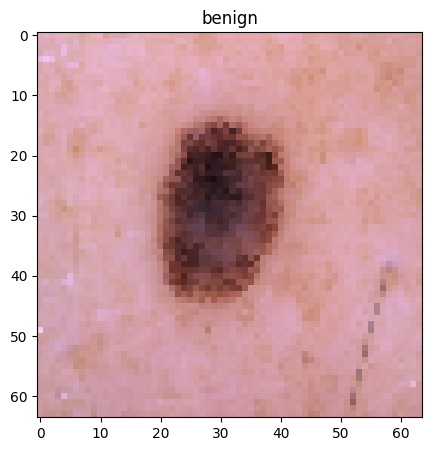

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0]/255)
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'malignant')

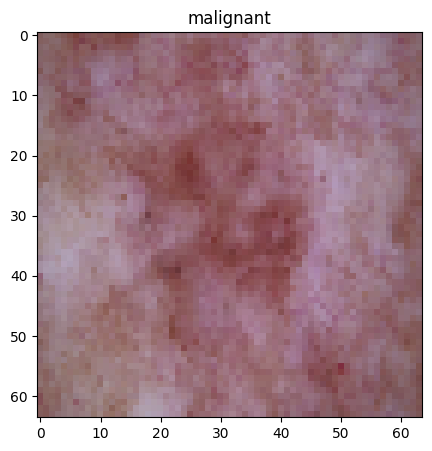

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0]/255)
plt.title(labels[train[-1][1]])

In [9]:
from sklearn.model_selection import train_test_split

X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)


# resize data for deep learning
X = np.array(X).reshape(-1, img_size, img_size, 3)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [10]:
X_train = X_train / 255
X_test = X_test / 255

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=90,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

# Fit the data generator on training data
datagen.fit(X_train)

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import  accuracy_score, confusion_matrix
from keras import layers

model = Sequential()

model.add(Conv2D(64, (5, 5), input_shape=(img_size, img_size, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(128, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(256, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))

# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 64)            │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 64)            │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 16)            │           9,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,219,401 (4.65 MB)

 Trainable params: 1,219,277 (4.65 MB)

 Non-trainable params: 124 (496.00 B)

In [14]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), callbacks=[lr_reduction], validation_data=(X_test, y_test), epochs=30)

# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy: {scores[1]*100:.2f}% \nError: {(1-scores[1])*100:.2f}%")

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 69s 700ms/step - accuracy: 0.5642 - loss: 0.6747 - val_accuracy: 0.7379 - val_loss: 0.5104 - learning_rate: 0.0010
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 672ms/step - accuracy: 0.7582 - loss: 0.4822 - val_accuracy: 0.6985 - val_loss: 0.5720 - learning_rate: 0.0010
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 658ms/step - accuracy: 0.7697 - loss: 0.4879 - val_accuracy: 0.4621 - val_loss: 0.7670 - learning_rate: 0.0010
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.7662 - loss: 0.4807
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 668ms/step - accuracy: 0.7661 - loss: 0.4808 - val_accuracy: 0.5121 - val_loss: 0.7002 - learning_rate: 0.0010
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 665ms/step - accuracy: 0.7760 - loss: 0.4679 - val_accuracy: 0.5455 - val_loss: 0.6861 - learning_rate: 5.0000e-04
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 658ms/step - accuracy: 0.7978 - loss: 

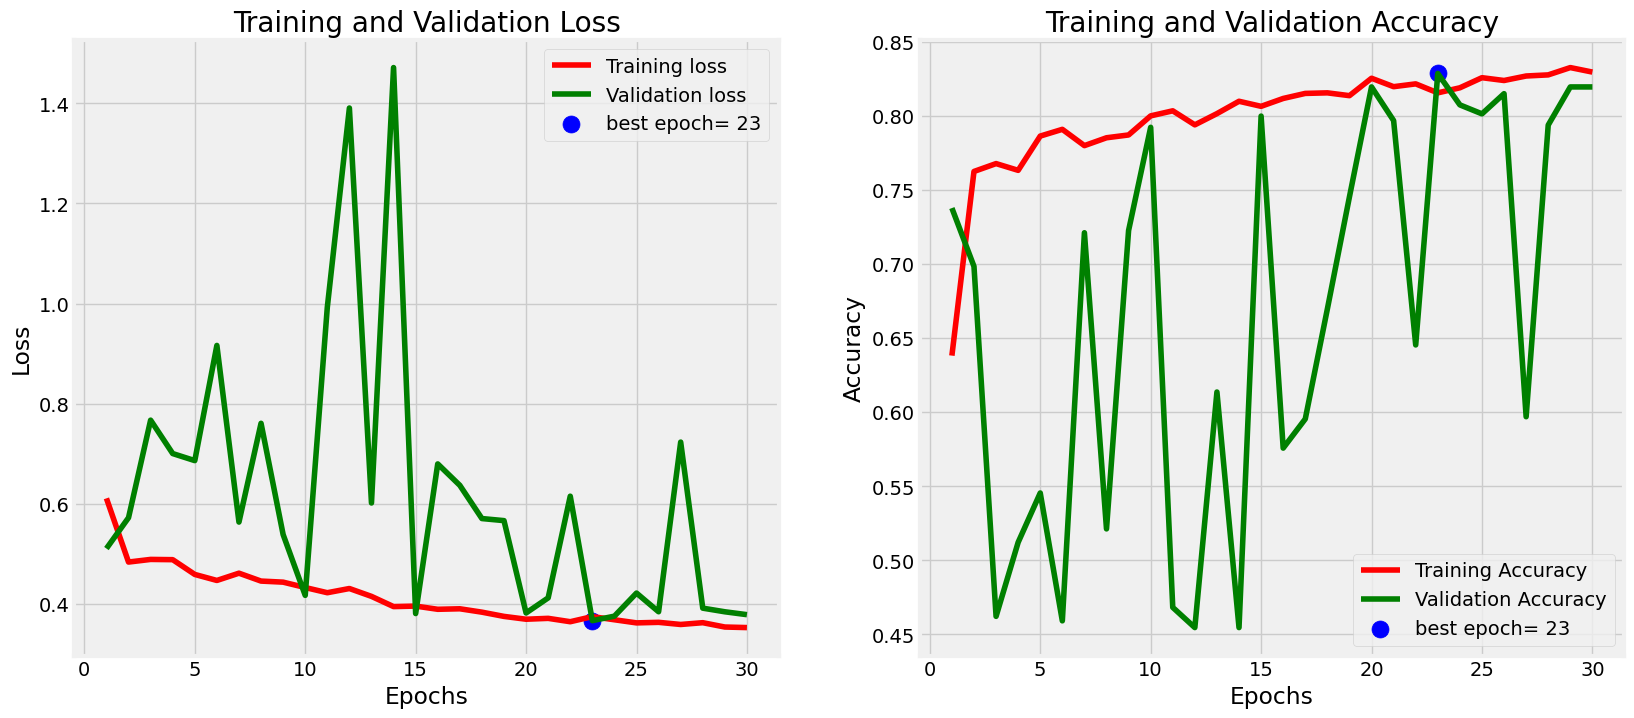

In [15]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [16]:
# loading the model
pretrained_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(img_size,img_size , 3))

In [17]:
# make the model layers un trainable to use the saved weights

for i in pretrained_model.layers:
    i.trainable = False

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D

# Set up EarlyStopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Set up ModelCheckpoint to save the best model based on validation loss
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Build the model
model = Sequential()
model.add(pretrained_model)  # Add the pre-trained model
model.add(GlobalAveragePooling2D())  # Reduce dimensionality
model.add(BatchNormalization())  # Normalize activations
model.add(Dense(128, activation='relu'))  # Fully connected layer
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(32, activation='relu'))  # Fully connected layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with both callbacks
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint, lr_reduction],  # Add the EarlyStopping and ModelCheckpoint callbacks
                    epochs=25)

# Evaluate the best model
best_model_scores = model.evaluate(X_test, y_test, verbose=0)

# Print the accuracy and error
print(f"Best Model Accuracy: {best_model_scores[1] * 100:.2f}% \nError: {(1 - best_model_scores[1]) * 100:.2f}%")

Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6208 - loss: 0.6352
Epoch 1: val_loss improved from inf to 0.72840, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 471ms/step - accuracy: 0.6215 - loss: 0.6346 - val_accuracy: 0.5455 - val_loss: 0.7284 - learning_rate: 0.0010
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7583 - loss: 0.5062
Epoch 2: val_loss improved from 0.72840 to 0.61115, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 380ms/step - accuracy: 0.7582 - loss: 0.5062 - val_accuracy: 0.6288 - val_loss: 0.6111 - learning_rate: 0.0010
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7704 - loss: 0.4875
Epoch 3: val_loss did not improve from 0.61115
83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 357ms/step - accuracy: 0.7703 - loss: 0.4876 - val_accuracy: 0.5939 - val_loss: 0.6467 - learning_rate: 0.0010
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7719 - loss: 0.4661
Epoch 4: val_loss

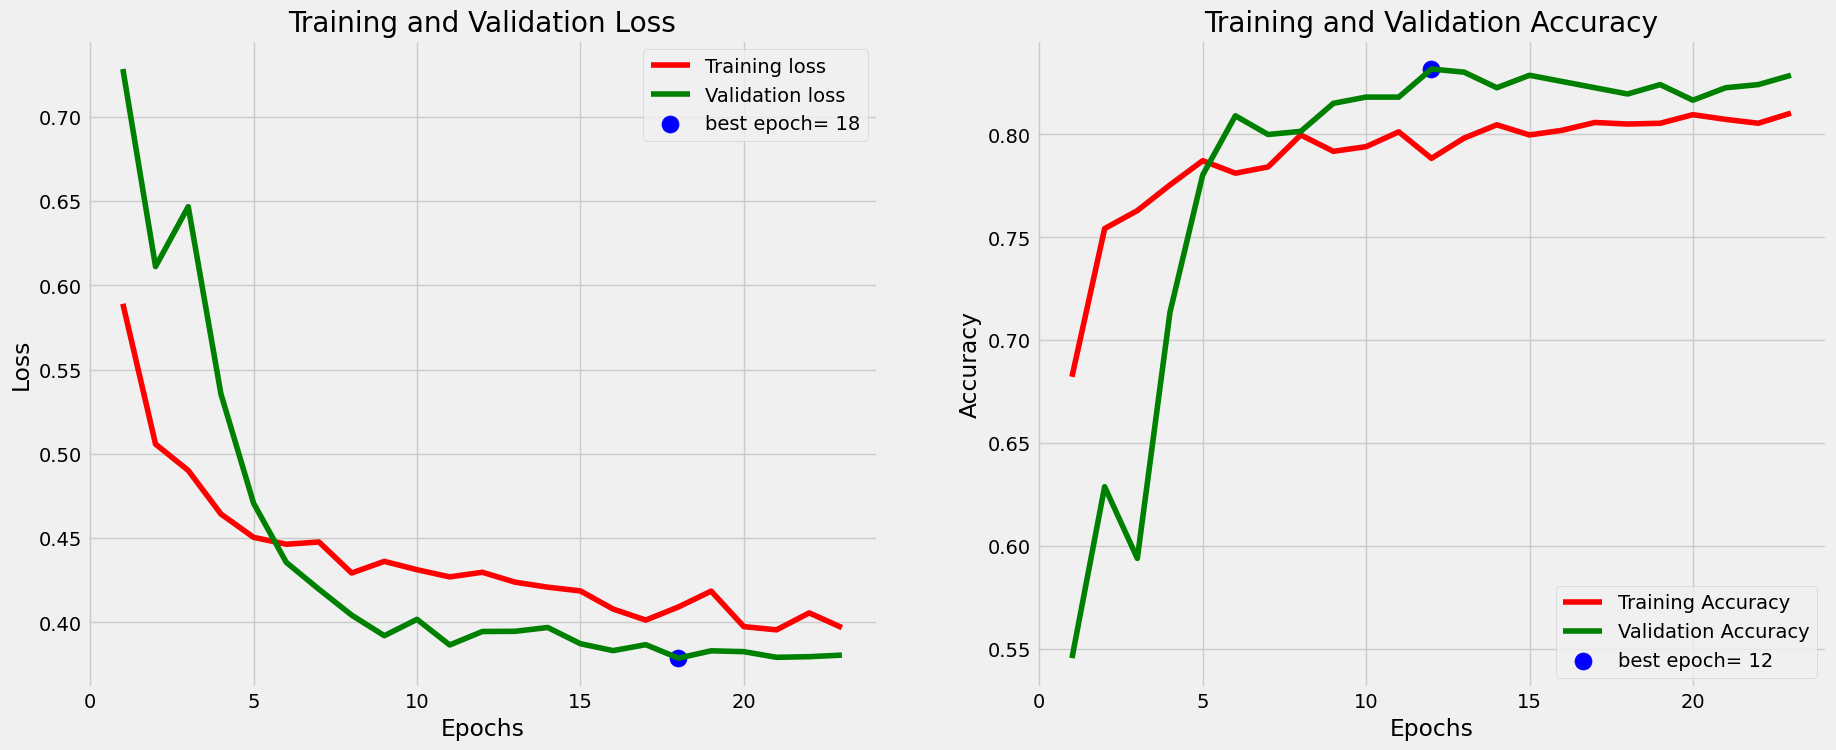

In [19]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [20]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Set up EarlyStopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Set up ModelCheckpoint to save the best model based on validation loss
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

for i in base_model.layers[:15]:
    i.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
history = model.fit(X_train, y_train, batch_size=32, 
                    callbacks=[early_stopping, model_checkpoint, lr_reduction],
                    validation_data=(X_test, y_test), epochs=25)

# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy: {scores[1]*100:.2f}% \nError: {(1-scores[1])*100:.2f}%")

Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.6033 - loss: 0.6610
Epoch 1: val_loss improved from inf to 0.42763, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 881ms/step - accuracy: 0.6045 - loss: 0.6598 - val_accuracy: 0.7636 - val_loss: 0.4276 - learning_rate: 0.0010
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.8440 - loss: 0.3820
Epoch 2: val_loss improved from 0.42763 to 0.32094, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 69s 832ms/step - accuracy: 0.8440 - loss: 0.3818 - val_accuracy: 0.8424 - val_loss: 0.3209 - learning_rate: 0.0010
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.8629 - loss: 0.3087
Epoch 3: val_loss did not improve from 0.32094
83/83 ━━━━━━━━━━━━━━━━━━━━ 68s 821ms/step - accuracy: 0.8628 - loss: 0.3087 - val_accuracy: 0.8273 - val_loss: 0.3784 - learning_rate: 0.0010
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.8662 - loss: 0.3038
Epoch 4: val_loss

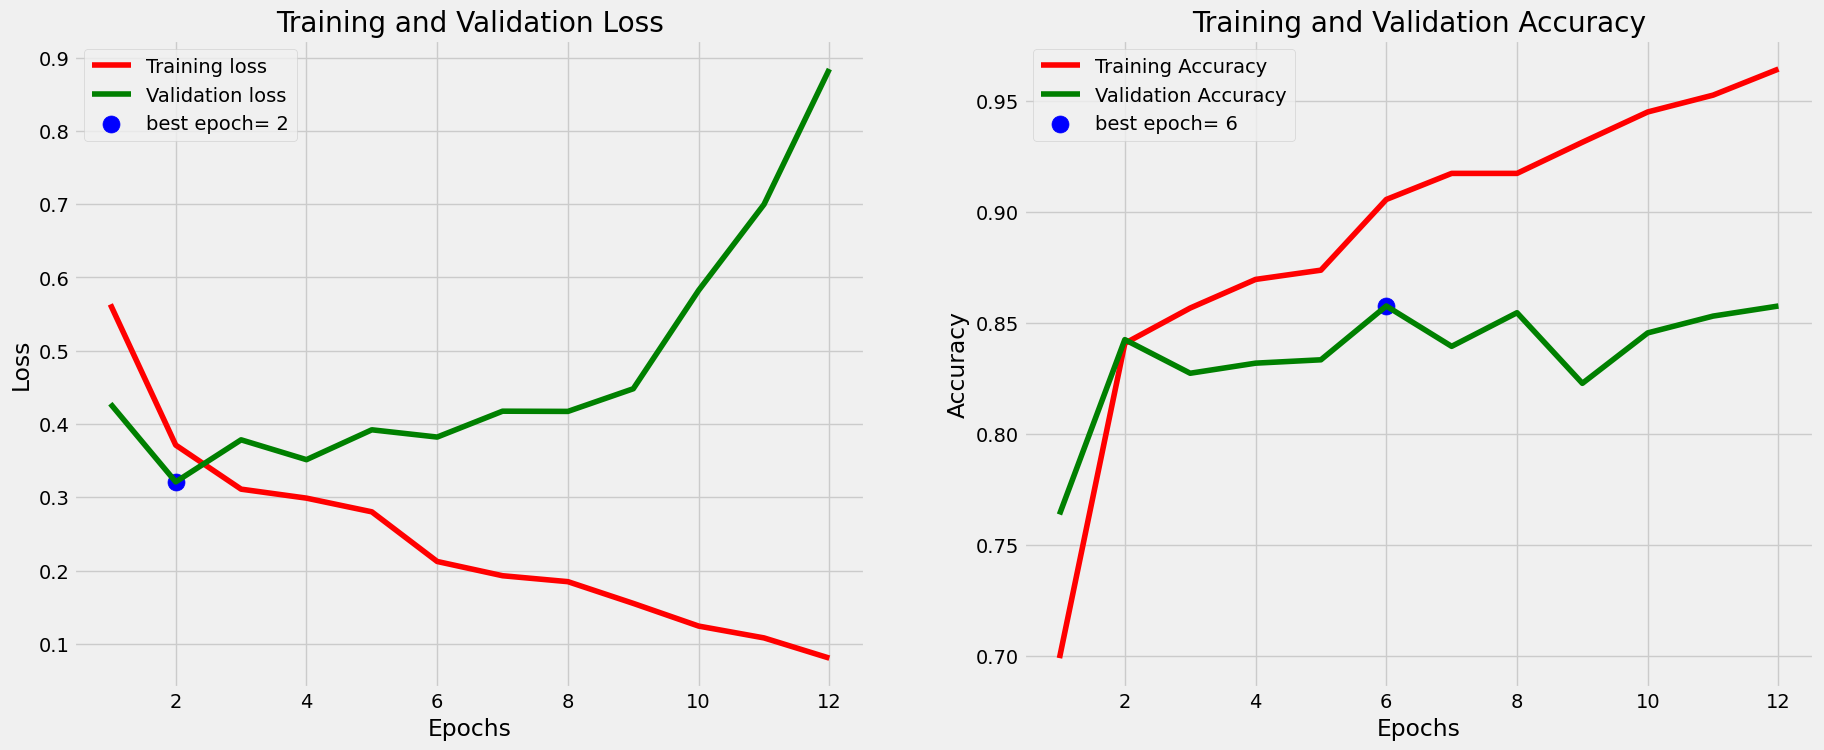

In [22]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [23]:
# Save the model as an HDF5 file
#model.save('skin_model.keras')


In [24]:
#import shutil

# Move the HDF5 file to the desired download location (e.g., your Downloads folder)
#shutil.move('skin_model.keras', r'C:\Users\HP\Desktop\Skin Cancer Detection')


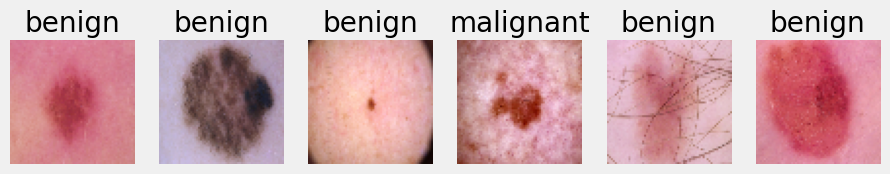

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(data, labels, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        # Normalize if necessary, or just display directly
        if np.max(data[i]) > 1:  # Assuming data is uint8
            plt.imshow(data[i] / 255.0)  # Normalize for display
        else:
            plt.imshow(data[i])  # Already normalized
        plt.title(labels[i])  # Set the title to the corresponding label
        plt.axis('off')  # Hide the axis
    plt.show()

# Example usage (using the train set)
# Ensure your X_train and labels are correctly defined
plot_sample_images(X_train, [labels[i] for i in y_train], num_samples=6)
